# NFL Against the Spread Classification

- Building a classification model to predict if an NFL team will beat, push, or lose to the spread
- We will test multiple classification models and parameters to find the best model

In [20]:
# Import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


# scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector

# models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, accuracy_score, roc_curve, auc

# pipeline and grid search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# multiclass ROC curve

from yellowbrick.classifier import ROCAUC

In [3]:
# load in csv file

df = pd.read_csv("../Data/nfl_game_data.csv")

df.head()

,game_id,season,team,opponent,spread_line,coach,roof,ats_win,location,epa,...,rush_yds_per_attempt,int,fumbles_lost,penalty_yards,def_epa,def_pass_yds_per_attempt,def_rush_yds_per_attempt,def_int,forced_fumbles,def_penlty_yards
0,2001_01_CHI_BAL,2001,BAL,CHI,10.5,Brian Billick,outdoors,win,home,-0.077838,...,1.800000,0,2,15,-0.247703,5.750000,2.000000,2,0,16
1,2001_01_NO_BUF,2001,BUF,NO,-1.5,Gregg Williams,outdoors,lose,home,-0.340673,...,4.464286,3,0,15,0.040729,11.611111,4.192308,0,0,0
2,2001_01_NE_CIN,2001,CIN,NE,0.0,Dick LeBeau,outdoors,win,home,0.065117,...,4.757576,0,1,0,0.004959,10.954545,3.238095,0,0,0
3,2001_01_SEA_CLE,2001,CLE,SEA,-4.0,Butch Davis,outdoors,win,home,-0.137322,...,3.600000,1,0,0,-0.118707,8.900000,3.740741,2,0,15
4,2001_01_TB_DAL,2001,DAL,TB,-9.0,Dave Campo,outdoors,win,home,-0.429948,...,4.304348,2,1,10,-0.029573,7.800000,2.151515,1,1,0


In [4]:
# drop unnecessary columns (game_id, team, )
# convert season column from integer to category
df["season"] = df.season.astype('category')

In [5]:
df = df.drop(columns=["game_id", "team"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10326 entries, 0 to 10325
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   season                    10326 non-null  category
 1   opponent                  10326 non-null  object  
 2   spread_line               10326 non-null  float64 
 3   coach                     10326 non-null  object  
 4   roof                      10326 non-null  object  
 5   ats_win                   10326 non-null  object  
 6   location                  10326 non-null  object  
 7   epa                       10326 non-null  float64 
 8   pass_yds_per_attempt      10326 non-null  float64 
 9   rush_yds_per_attempt      10326 non-null  float64 
 10  int                       10326 non-null  int64   
 11  fumbles_lost              10326 non-null  int64   
 12  penalty_yards             10326 non-null  int64   
 13  def_epa                   10326 non-null  floa

In [6]:
# Create a function to use to run multiple models
def test_model(model, data):
    X_train, X_test, y_train, y_test = data
    clf = model.fit(X_train, y_train)
    prds = model.predict(X_test)
#     print(f'Model: ')
    print(f'Train score: {clf.score(X_train, y_train)}')
    print(f"-"*40)
    print(f'Test Score: {clf.score(X_test, y_test)}')
    print(f"-"*40)
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, prds)}")
    print(f"-"*40)
    print(f'''Confusion Matrix: 
{confusion_matrix(y_test, prds)}''')
    print(f"-"*40)
    print(f'''Classification Report:
{classification_report(y_test, prds)}''')
    plt.show()

# split data into x and y 

X = df.drop("ats_win", axis=1)
y = df['ats_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
    
data = [X_train, X_test, y_train, y_test]

In [7]:
# Create pipeline
numeric_features = ["spread_line", "epa", "pass_yds_per_attempt", "rush_yds_per_attempt", "int", "fumbles_lost", \
                    "penalty_yards", "def_epa", "def_pass_yds_per_attempt", "def_rush_yds_per_attempt", "def_int", \
                    "forced_fumbles", "def_penlty_yards"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["season", "opponent", "coach", "roof", "location"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Logistic Regression Model

In [21]:
log_regression_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=10000))])

test_model(log_regression_model, data)

Train score: 0.813918096292197
----------------------------------------
Test Score: 0.7989025177533893
----------------------------------------
Cohen's Kappa: 0.6081706915005058
----------------------------------------
Confusion Matrix: 
[[1265    0  267]
 [  44    0   39]
 [ 273    0 1210]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.80      0.83      0.81      1532
        push       0.00      0.00      0.00        83
         win       0.80      0.82      0.81      1483

    accuracy                           0.80      3098
   macro avg       0.53      0.55      0.54      3098
weighted avg       0.78      0.80      0.79      3098



### SGD Classifier Model

In [22]:
SGDC = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", SGDClassifier(max_iter=10000))])

test_model(SGDC, data)

Train score: 0.8024349750968456
----------------------------------------
Test Score: 0.7921239509360878
----------------------------------------
Cohen's Kappa: 0.5953781187091928
----------------------------------------
Confusion Matrix: 
[[1233    0  299]
 [  43    0   40]
 [ 260    2 1221]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.80      0.80      0.80      1532
        push       0.00      0.00      0.00        83
         win       0.78      0.82      0.80      1483

    accuracy                           0.79      3098
   macro avg       0.53      0.54      0.54      3098
weighted avg       0.77      0.79      0.78      3098



### KNeighbors Classifier Model

In [10]:
kn = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())])

test_model(kn, data)

Train score: 0.8395130049806309
----------------------------------------
Test Score: 0.7646868947708199
----------------------------------------
Cohen's Kappa: 0.5427895956200608
----------------------------------------
Confusion Matrix: 
[[1245    4  283]
 [  46    0   37]
 [ 351    8 1124]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.76      0.81      0.78      1532
        push       0.00      0.00      0.00        83
         win       0.78      0.76      0.77      1483

    accuracy                           0.76      3098
   macro avg       0.51      0.52      0.52      3098
weighted avg       0.75      0.76      0.76      3098



k: 1, Train/Test Score: 1.000/0.686
k: 3, Train/Test Score: 0.857/0.737
k: 5, Train/Test Score: 0.840/0.765
k: 7, Train/Test Score: 0.824/0.772
k: 9, Train/Test Score: 0.819/0.769
k: 11, Train/Test Score: 0.816/0.778
k: 13, Train/Test Score: 0.814/0.784
k: 15, Train/Test Score: 0.814/0.791
k: 17, Train/Test Score: 0.813/0.792
k: 19, Train/Test Score: 0.808/0.793
k: 21, Train/Test Score: 0.806/0.794
k: 23, Train/Test Score: 0.806/0.795
k: 25, Train/Test Score: 0.809/0.796
k: 27, Train/Test Score: 0.808/0.798
k: 29, Train/Test Score: 0.807/0.796
k: 31, Train/Test Score: 0.806/0.794
k: 33, Train/Test Score: 0.805/0.795
k: 35, Train/Test Score: 0.804/0.796
k: 37, Train/Test Score: 0.803/0.794
k: 39, Train/Test Score: 0.802/0.793


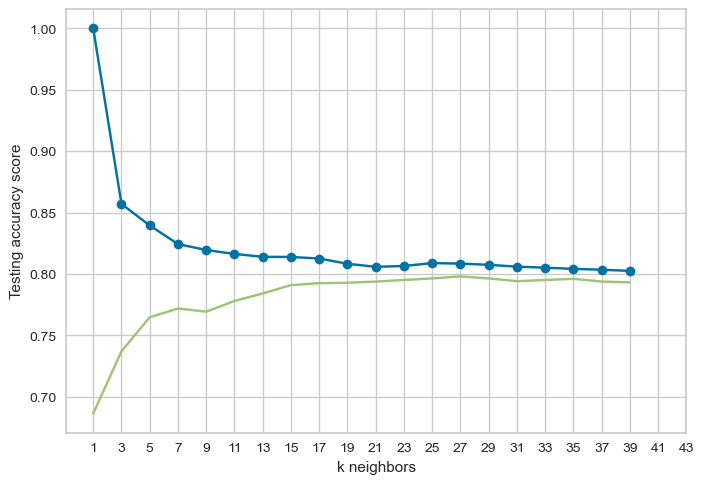

In [11]:
# Loop through different k values to find which has the highest accuracy
train_scores = []
test_scores = []
for k in range(1, 40, 2):
    knn = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=k))])
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 40, 2), train_scores, marker='o')
plt.plot(range(1, 40, 2), test_scores, marker="x")
loc, labels = plt.xticks()
plt.xticks(np.arange(1, max(loc), step=2))
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [23]:
kn = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = 27))])

test_model(kn, data)

Train score: 0.8083840619811843
----------------------------------------
Test Score: 0.7979341510652034
----------------------------------------
Cohen's Kappa: 0.6061859342024117
----------------------------------------
Confusion Matrix: 
[[1277    0  255]
 [  42    0   41]
 [ 288    0 1195]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.79      0.83      0.81      1532
        push       0.00      0.00      0.00        83
         win       0.80      0.81      0.80      1483

    accuracy                           0.80      3098
   macro avg       0.53      0.55      0.54      3098
weighted avg       0.78      0.80      0.79      3098



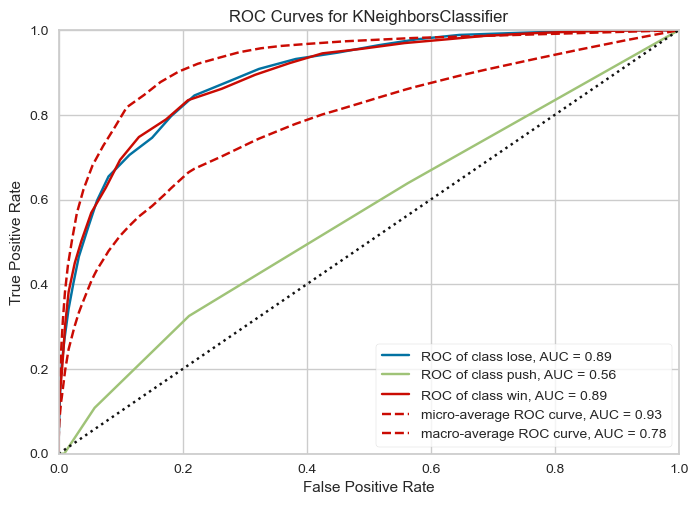

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [25]:
visualizer = ROCAUC(kn, classes=["lose", "push", "win"])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### Random Forest Classifier Model

In [24]:
rf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())])

test_model(rf, data)

Train score: 1.0
----------------------------------------
Test Score: 0.8005164622336992
----------------------------------------
Cohen's Kappa: 0.611268985154606
----------------------------------------
Confusion Matrix: 
[[1272    0  260]
 [  47    0   36]
 [ 275    0 1208]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.80      0.83      0.81      1532
        push       0.00      0.00      0.00        83
         win       0.80      0.81      0.81      1483

    accuracy                           0.80      3098
   macro avg       0.53      0.55      0.54      3098
weighted avg       0.78      0.80      0.79      3098



In [26]:
# Define a grid of parameters to test in the model
# Code adapted from Finn Qiao @ 
# https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

# Create first pipeline for base without reducing features.

param_grid = [
    {'classifier' : [LogisticRegression(max_iter = 10000)],
     'classifier__penalty' : ['l1', 'l2']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10))}
]

# Create grid search object

clf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [27]:
test_model(best_clf, data)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Train score: 0.813918096292197
----------------------------------------
Test Score: 0.7989025177533893
----------------------------------------
Cohen's Kappa: 0.6081706915005058
----------------------------------------
Confusion Matrix: 
[[1265    0  267]
 [  44    0   39]
 [ 273    0 1210]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

        lose       0.80      0.83      0.81      1532
        push       0.00      0.00      0.00        83
         win       0.80      0.82      0.81      1483

    accuracy                           0.80      3098
   macro avg       0.53      0.55      0.54      3098
weighted avg       0.78      0.80      0.79      3098

